## Imports


In [18]:
# import sys
# sys.path.append('/media/linux-stuff/gpt2-diff/scripts')

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch import device
from torch.optim.lr_scheduler import LambdaLR

import math
import os
import pandas as pd

from scripts.config import gpt2config
from scripts.model import DiffusionLM, LMEmbedding, Denoiser, Decoding
from scripts.utils import (
    MyTokenizer, 
    get_next_log_filename, 
    save_checkpoint, 
    load_checkpoint,
    posterior_mean,
    rounding_weight,
    get_batch,
    finalize_tokens,
    reverse_diffusion_with_clamping,
    visualize_embeddings_2d,
    fwd_diffusion
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
torch.set_float32_matmul_precision('high')

Using device: cuda


## Tokenizer

In [19]:
tokenizer = MyTokenizer(max_len=13)
tokenizer.decode(tokenizer.encode("Hello, tiktoken is fast!"))

'<bos>Hello, tiktoken is fast!<eos><pad><pad><pad>'

In [20]:
config = gpt2config(n_vocab=tokenizer.n_vocab,n_embed=16,mlp_expansion=4,n_latent=512)
model = DiffusionLM(config).to(device)
print(f"Total Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
print(config.n_vocab)

Total Model parameters: 39.66M
50260


## Testing Initialization

In [21]:
sample_input = "Once upon a time in a land far away, there lived a"
sample_tokens = tokenizer.encode(sample_input)
sample_input_ids = torch.tensor([sample_tokens], device=device)  # (1, sequence_length)
sample_time_step = torch.tensor([10], device=device)  # (1,)

In [22]:
sample_input_ids.shape

torch.Size([1, 13])

In [23]:
sample_output, sample_logits = model(sample_input_ids, sample_time_step)  # (1, sequence_length, n_embed)

token_ids = finalize_tokens(sample_output, model.embedding.embed.weight)
decoded_output = tokenizer.decode(token_ids.squeeze(0).tolist())
print("Decoded Text:",decoded_output)

Decoded Text:  slide thwVs furniture Mosque Christensen). Many homework horse ori stealingened


## Forward Diffusion

In [24]:
# noisy_input = fwd_diffusion(model.embedding(sample_input_ids), torch.tensor([1000], device=device), alphas)

# token_ids = finalize_tokens(noisy_input, model.embedding.embed.weight)
# decoded_output = tokenizer.decode(token_ids.squeeze(0).tolist())
# print("Decoded Text:",decoded_output)

## Loading Datasets

In [25]:
import pandas as pd

# Load E2E dataset - extract text from 'ref' column
df = pd.read_csv('datasets/e2e-dataset/trainset.csv')
text = ' '.join(df['ref'].tolist())

print(f"Dataset length: {len(text)} characters")
print(f"Number of samples: {len(df)}")
print(f"First sample: {df['ref'][0]}")

Dataset length: 4646702 characters
Number of samples: 42061
First sample: The Vaults pub near Café Adriatic has a 5 star rating.  Prices start at £30.


In [26]:
# from datasets import load_dataset
# import pandas as pd

# # Load ROCStories dataset from HuggingFace
# rocstories = load_dataset("mintujupally/ROCStories")

# print(f"Dataset: {rocstories}")
# print(f"Train samples: {len(rocstories['train'])}")
# print(f"First story: {rocstories['train'][0]['text']}")

# # Convert to pandas DataFrame with 'ref' column
# train_df = pd.DataFrame({'ref': rocstories['train']['text']})
# test_df = pd.DataFrame({'ref': rocstories['test']['text']})

# # Save to CSV files
# train_df.to_csv('datasets/rocstories_train.csv', index=False)
# test_df.to_csv('datasets/rocstories_test.csv', index=False)

# print(f"\nSaved {len(train_df)} training samples to datasets/ROCStories/rocstories_train.csv")
# print(f"Saved {len(test_df)} test samples to datasets/ROCStories/rocstories_test.csv")

In [27]:
# Split into train and test
train_size = int(0.9 * len(df))
train_df = df[:train_size].reset_index(drop=True)
test_df = df[train_size:].reset_index(drop=True)

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

# Pre-encode all sequences for training efficiency
print("\nEncoding training data...")
train_encoded = []
for idx, row in train_df.iterrows():
    encoded = tokenizer.encode(row['ref'], max_len=64)  # Use fixed sequence length
    train_encoded.append(encoded)
    if (idx + 1) % 5000 == 0:
        print(f"Encoded {idx + 1}/{len(train_df)} train samples")

print("\nEncoding test data...")
test_encoded = []
for idx, row in test_df.iterrows():
    encoded = tokenizer.encode(row['ref'], max_len=64)
    test_encoded.append(encoded)

# Convert to tensors
train_encoded = torch.tensor(train_encoded, dtype=torch.long)
test_encoded = torch.tensor(test_encoded, dtype=torch.long)

print(f"\nTrain encoded shape: {train_encoded.shape}")
print(f"Test encoded shape: {test_encoded.shape}")

Train samples: 37854, Test samples: 4207

Encoding training data...
Encoded 5000/37854 train samples
Encoded 10000/37854 train samples
Encoded 15000/37854 train samples
Encoded 20000/37854 train samples
Encoded 25000/37854 train samples
Encoded 30000/37854 train samples
Encoded 35000/37854 train samples

Encoding test data...

Train encoded shape: torch.Size([37854, 64])
Test encoded shape: torch.Size([4207, 64])


In [28]:
# Test batch
w_stack = get_batch('train', batch_size=4, sequence_length=64, train_encoded=train_encoded, test_encoded=test_encoded, device=device)
print(f"Batch shape: {w_stack.shape}")
print(f"First sequence decoded: {tokenizer.decode(w_stack[0].tolist())}")

Batch shape: torch.Size([4, 64])
First sequence decoded: <bos>Cotto is a Japanese restaurant near Ranch that is children friendly with a low customer rating.<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


## Training Loop


In [29]:
# Training configuration
max_iters = 100000  
learning_rate = 3e-3
eval_iters = 1000  # Much fewer eval iterations (was 200!)
batch_size = 16  # Larger batch for better GPU utilization
sequence_length = 64
T = 1000
num_timestep_samples = 4  # Sample 8 timesteps per iteration for better gradient estimate



In [30]:
# Fixed alpha schedule - simple sqrt schedule
t = torch.arange(0, T+1, device=device, dtype=torch.float32)
alpha_bars = 1 - torch.sqrt(t / T)  # Goes from ~0 to 1-sqrt(1)=0
alpha_bars = torch.clamp(alpha_bars, min=0.001, max=0.999)
alphas = torch.zeros(T+1, device=device) #alpha_0 to alpha_T
alphas[0] = alpha_bars[0]
alphas[1:] = alpha_bars[1:] / alpha_bars[:-1]
alphas = torch.clamp(alphas, min=0.001, max=0.999)

# Precompute sqrt terms for efficiency
sqrt_ab = torch.sqrt(alpha_bars)
sqrt_1mab = torch.sqrt(1 - alpha_bars)

print(f"Alpha bars range: [{alpha_bars.min():.4f}, {alpha_bars.max():.4f}]")
print(f"Alphas range: [{alphas.min():.4f}, {alphas.max():.4f}]")


Alpha bars range: [0.0010, 0.9990]
Alphas range: [0.6665, 0.9990]


In [31]:
model = torch.compile(model, mode='max-autotune')  # or 'max-autotune' for more optimization


In [32]:
optimizer_model = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay=0.0)
lr_lambda = lambda step: 1.0 - (step / float(max_iters))
scheduler_model = LambdaLR(optimizer_model, lr_lambda=lr_lambda)

#### Training Loop

In [33]:
log_file = get_next_log_filename('logs')
print(f"Logging to: {log_file}")

with open(log_file, 'w') as f:
    f.write("Iteration,Total_Loss,Denoising_Loss,Posterior_Loss,Anchor_Loss,Rounding_Loss\n")

checkpoint_counter = 0

for it in range(0, max_iters):

    w = get_batch('train', batch_size, sequence_length, train_encoded=train_encoded, test_encoded=test_encoded, device=device)
    w_emb = model.embedding(w)

    x0 = w_emb + 0.1 * torch.randn_like(w_emb)
    total_loss = 0.0
    
    eps = torch.randn_like(x0)
    denoising_loss = 0.0
    for _ in range(num_timestep_samples):
        t_random = torch.randint(1, T+1, (batch_size,), device=device)
        t_idx = t_random
        sqrt_ab_t = sqrt_ab[t_idx].view(batch_size, 1, 1)
        sqrt_1mab_t = sqrt_1mab[t_idx].view(batch_size, 1, 1)
        
        xt = sqrt_ab_t * x0 + sqrt_1mab_t * eps
        x0_hat = model.denoiser(xt, t_random)
        x0_hat = torch.clamp(x0_hat, min=-10.0, max=10.0)
        # print(torch.sum(x0_hat))
        denoising_loss += F.mse_loss(x0_hat, x0)
    
    denoising_loss = denoising_loss / num_timestep_samples + 1e-8
    total_loss += denoising_loss
    
    t_T = torch.full((batch_size,), T, device=device)
    xT = sqrt_ab[-1] * x0 + sqrt_1mab[-1] * eps
    x0_hat_T = model.denoiser(xT, t_T)
    x0_hat_T = torch.clamp(x0_hat_T, min=-10.0, max=10.0)
    mu_hat_T = posterior_mean(xT, x0, T, alpha_bars, alphas)
    posterior_loss = F.mse_loss(mu_hat_T, torch.zeros_like(mu_hat_T)) + 1e-8
    total_loss += posterior_loss
    
    xt_1 = sqrt_ab[1] * x0 + sqrt_1mab[1] * torch.rand_like(x0)
    x0_hat_1 = model.denoiser(xt_1, torch.ones(batch_size, device=device))
    x0_hat_1 = torch.clamp(x0_hat_1, min=-10.0, max=10.0)
    anchor_loss = F.mse_loss(x0_hat_1, w_emb) + 1e-8
    total_loss += anchor_loss

    logits = x0_hat_1 @ model.embedding.embed.weight.T
    logits = torch.clamp(logits, min=-100.0, max=100.0)
    rounding_loss = rounding_weight(it, max_iters) * (F.cross_entropy(logits.view(-1, config.n_vocab), w.view(-1)) + 1e-8)
    total_loss += rounding_loss
    
    if torch.isnan(total_loss) or torch.isinf(total_loss):
        print(f"\n{'='*70}")
        print(f"TRAINING STOPPED: NaN/Inf detected at iteration {it}")
        print(f"{'='*70}")
        print(f"Loss Diagnostics:")
        print(f"  Total Loss:     {total_loss.item() if not torch.isnan(total_loss) else 'NaN'}")
        print(f"  Denoising:      {denoising_loss.item()}")
        print(f"  Posterior:      {posterior_loss.item()}")
        print(f"  Anchor:         {anchor_loss.item()}")
        print(f"  Rounding:       {rounding_loss.item()}")
        print(f"\nModel Output Statistics:")
        print(f"  x0_hat range:   [{x0_hat.min().item():.2f}, {x0_hat.max().item():.2f}]")
        print(f"  logits range:   [{logits.min().item():.2f}, {logits.max().item():.2f}]")
        print(f"\nGradient Statistics:")
        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        print(f"  Total grad norm: {total_norm:.4f}")
        print(f"{'='*70}\n")
        break
    
    optimizer_model.zero_grad(set_to_none=True)
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    optimizer_model.step()
    scheduler_model.step()

    with open(log_file, 'a') as f:
        f.write(f"{it},{total_loss.item():.6f},{denoising_loss.item():.6f},{posterior_loss.item():.6f},{anchor_loss.item():.6f},{rounding_loss.item():.6f}\n")

    if it % eval_iters == 0:
        print(f"Iter {it}: loss = {total_loss.item():.4f}, denoising = {denoising_loss.item():.4f}, posterior = {posterior_loss.item():.4f}, anchor = {anchor_loss.item():.4f}, rounding = {rounding_loss.item():.4f}")

    if it % 5000 == 0 and it > 0:
        checkpoint_name = f"training_ckpt_{checkpoint_counter % 2}"
        save_checkpoint(model, config, alpha_bars, T, checkpoint_name, save_individual=False)
        checkpoint_counter += 1

print(f"\nTraining complete! Logs saved to: {log_file}")

Logging to: logs/log_11.txt
Iter 0: loss = 17.4689, denoising = 1.1534, posterior = 0.9932, anchor = 1.1826, rounding = 14.1396
Iter 1000: loss = 2.8833, denoising = 0.3286, posterior = 0.9981, anchor = 0.1687, rounding = 1.3878
Iter 2000: loss = 1.9185, denoising = 0.3808, posterior = 1.0030, anchor = 0.1566, rounding = 0.3781
Iter 3000: loss = 1.4799, denoising = 0.2733, posterior = 1.0036, anchor = 0.0841, rounding = 0.1188
Iter 4000: loss = 1.4384, denoising = 0.2825, posterior = 0.9949, anchor = 0.0691, rounding = 0.0919
Iter 5000: loss = 1.4088, denoising = 0.2810, posterior = 1.0009, anchor = 0.0559, rounding = 0.0710
✓ Checkpoint saved to saved_models/checkpoints_training_ckpt_0/diff_lm_checkpoint.pt

Checkpoint summary:
  Directory: saved_models/checkpoints_training_ckpt_0
  Model params: 39.66M
  Timesteps (T): 1000
  Vocab size: 50260
Iter 6000: loss = 1.3448, denoising = 0.2534, posterior = 1.0002, anchor = 0.0487, rounding = 0.0425
Iter 7000: loss = 1.3476, denoising = 0.2

KeyboardInterrupt: 

In [35]:
with torch.no_grad():
    w = get_batch('train', 1, sequence_length,train_encoded=train_encoded, test_encoded=test_encoded, device=device)
    x0 = model.embedding(w)
    print(x0)
    eps = torch.randn_like(x0)

    for t in [1, T//4, T//2, T]:
        xt = sqrt_ab[t-1] * x0 + sqrt_1mab[t-1] * eps
        print(t, torch.norm(xt - x0).item())


tensor([[[ 0.2111, -0.0681, -0.0846,  ...,  0.3494, -0.5711,  1.0287],
         [-0.0627, -1.8739,  0.7709,  ...,  1.0371, -0.0178,  0.9259],
         [ 0.5957, -1.2836,  0.8134,  ..., -0.1105,  0.1164, -1.0158],
         ...,
         [-0.5643, -1.1473,  0.8957,  ..., -0.8779, -1.6988,  0.9521],
         [-0.5643, -1.1473,  0.8957,  ..., -0.8779, -1.6988,  0.9521],
         [-0.5643, -1.1473,  0.8957,  ..., -0.8779, -1.6988,  0.9521]]],
       device='cuda:0')
1 1.0082297325134277
250 24.600013732910156
500 31.112411499023438
1000 46.790218353271484


## Inference

In [54]:
context_length = 100
generated_tokens, generated_text = reverse_diffusion_with_clamping(
    model=model,
    config=config,
    tokenizer=tokenizer,
    alpha_bars=alpha_bars,
    T=T,
    context_length=context_length,
    batch_size=1,
    clamping_start=0.8,
    skip_step=10,
    display_at_steps=[T//2, 1],
    device=device
)


Starting Reverse Diffusion
Total Timesteps: 1000 | Context Length: 100
Clamping Start: 80% | Skip Step: 10

🌀 Initial State (t=1000, Pure Noise):
 stuff Indian meetings relaxed consistent European25 moderatelyChildrenval familyi greatestvalue Clare home continental check Me mealsPeople valuabled got tastes one surprising nightsmid that grab child atSit overlooking dollarIde its offers Eat diner ThoughNot incredible suitedent edible wine through beverages locationuns They Customers almost difficult ratingAsie sibling costri fans short served satisfactory riversnex moderately establishments sales differentFromhire betweenwood
----------------------------------------------------------------------

🔒 Clamping Intermediate State (t=500):
, a is a city the located It near customer in near moderately- shop near is of fast which city Crown. pricedide the House a a price found customers


Final Output:
 the food rivers is food and. food has food an near is restaurant. Café a near of- centre Pu

## Visualizing the Embedding Space

In [48]:
my_vocab_itos_list = [tokenizer.decode([i]) for i in range(config.n_vocab-4) or range(config.n_vocab-3, config.n_vocab)]

Pre-reducing dimensions with PCA...
Running 2D t-SNE on 3000 tokens...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.006s...
[t-SNE] Computed neighbors for 3000 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.084261
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.031586
[t-SNE] KL divergence after 1000 iterations: 1.076003
Performing POS tagging...


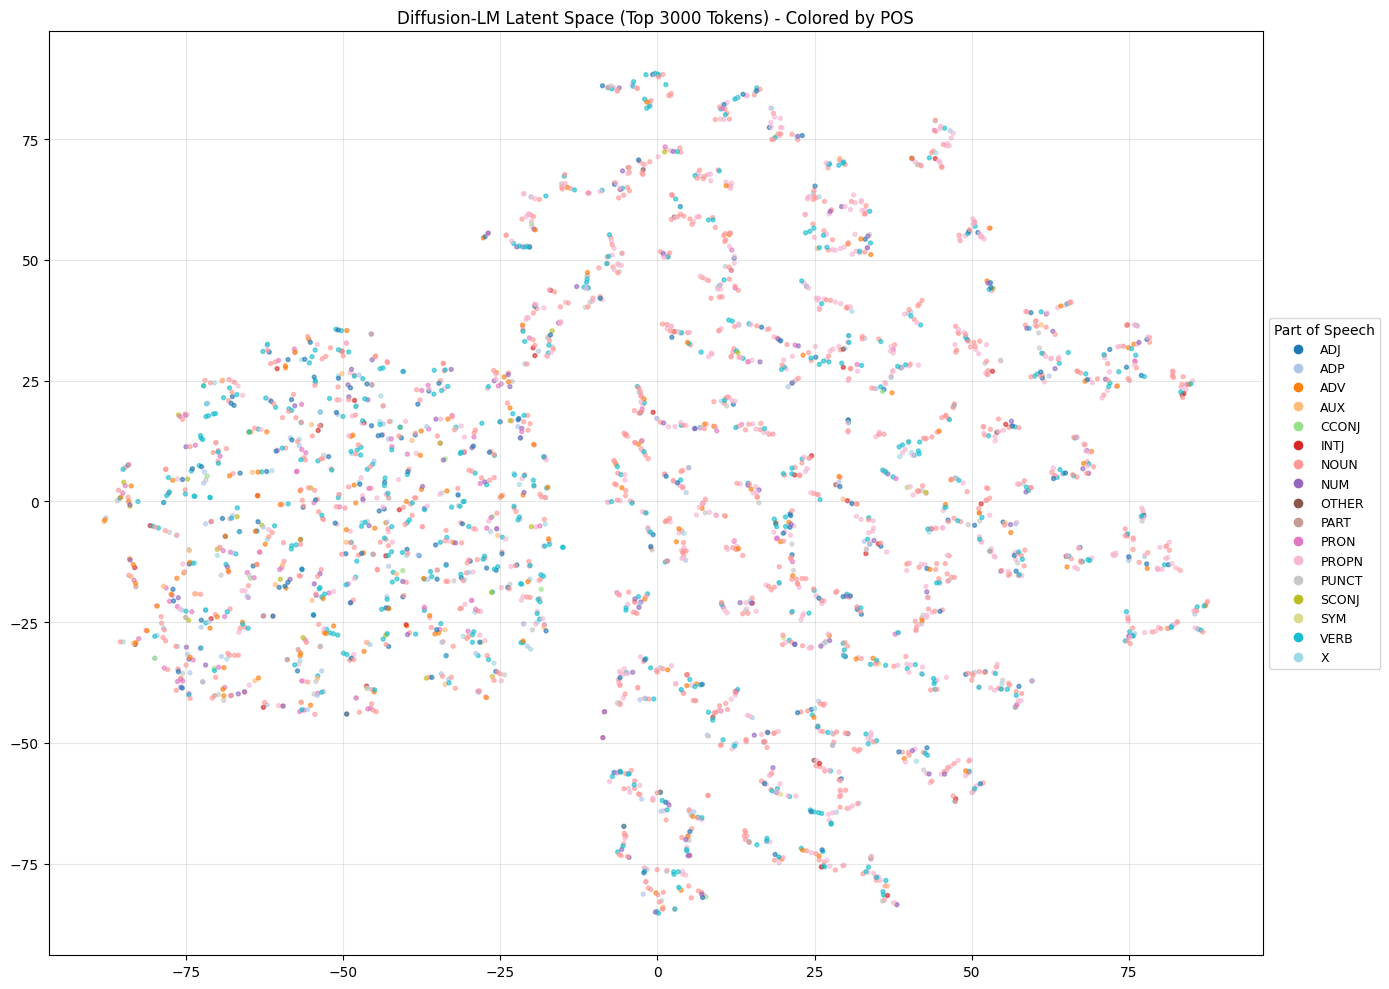


POS Tag Distribution:
  NOUN        :   874 (29.1%)
  PROPN       :   650 (21.7%)
  VERB        :   519 (17.3%)
  ADJ         :   193 (6.4%)
  ADV         :   156 (5.2%)
  NUM         :   127 (4.2%)
  PRON        :   108 (3.6%)
  ADP         :    98 (3.3%)
  PUNCT       :    79 (2.6%)
  X           :    58 (1.9%)
  AUX         :    38 (1.3%)
  INTJ        :    37 (1.2%)
  SCONJ       :    24 (0.8%)
  CCONJ       :    15 (0.5%)
  OTHER       :    12 (0.4%)
  PART        :     7 (0.2%)
  SYM         :     5 (0.2%)


In [49]:
visualize_embeddings_2d(model.embedding.embed, my_vocab_itos_list[:3000], top_n=3000)

## Saving/Load Model Checkpoints

In [44]:
# Save model checkpoint
save_checkpoint(
    model=model,
    config=config,
    alpha_bars=alpha_bars,
    T=T,
    checkpoint_name='E2E_20k',  # Customize as needed
    save_individual=True
)


✓ Checkpoint saved to saved_models/checkpoints_E2E_20k/diff_lm_checkpoint.pt
✓ Model state dict saved to saved_models/checkpoints_E2E_20k/model.pt

Checkpoint summary:
  Directory: saved_models/checkpoints_E2E_20k
  Model params: 39.66M
  Timesteps (T): 1000
  Vocab size: 50260


#### Loading Pre-trained Model

In [ ]:
# Load model checkpoint
model, config, alpha_bars, T, sqrt_ab, sqrt_1mab = load_checkpoint(
    checkpoint_name='training_ckpt_0',  # Update as needed
    device=device,
    eval_mode=True
)


Loading checkpoint from saved_models/checkpoints_training_ckpt_0/diff_lm_checkpoint.pt...
Detected compiled model, removing '_orig_mod.' prefix...

✓ Model loaded successfully!
  Config: n_vocab=50260, n_layer=12, n_embed=16
  T=1000, Alpha bars range: [0.0010, 0.9990]
  Total parameters: 39.66M


### Parts of Speech Controller 

In [ ]:
controller_config = gpt2config(n_vocab=tokenizer.n_vocab,n_layer=4)

In [ ]:
class POSClassifier(nn.Module):
    def __init__(self,config,pos_vocab):
        super().__init__()
        self.config = config
        self.embedding = LMEmbedding(config)
        self.denoiser = Denoiser(config)
        self.decoder = nn.Linear(config.n_embed, pos_vocab)  # Binary classification
        
    def forward(self,input_ids,time_step):
        input_embeddings = self.embedding(input_ids)  # (B,T,C)
        x = self.denoiser(input_embeddings,time_step)  # (B,T,C)
        logits = self.decoder(x)  # (B,T,pos_vocab)
        
        return logits

In [ ]:
controller = POSClassifier(controller_config,pos_vocab=10).to(device)